# All Imports

In [8]:
import importlib

from app import lib
importlib.reload(lib)
from app import utils
importlib.reload(utils)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers, callbacks
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score, classification_report
#import sagemaker
#from sagemaker.predictor import Predictor

# Globals

In [2]:
# Rate limiter for limiting API requests
RATE_LIMITER = lib.RateLimiter(max_calls_1=lib.MAX_REQUESTS_PER_SECOND, period_1=1, max_calls_2=lib.MAX_REQUESTS_PER_2MINUTE, period_2=140)

In [15]:
#utils.remove_duplicates()
#utils.get_features_tc("NA1_5024525952", RATE_LIMITER)

In [66]:
# Update check
print(utils.updateCheck())

97


# Getting Data

In [53]:
# Get a list of new match_ids
match_ids_list = utils.get_random_match_ids(RATE_LIMITER)

# Convert match_ids_list to dictionary 
match_ids = utils.match_ids_to_dictionary(match_ids_list)

# Store on CSV (Add onto existing matches) 
utils.store_match_ids(match_ids)

Rate limit reached for 100/2m. Sleeping for 121.27 seconds.
Rate limit reached for 100/2m. Sleeping for 121.94 seconds.
Rate limit reached for 100/2m. Sleeping for 121.65 seconds.
Rate limit reached for 100/2m. Sleeping for 121.30 seconds.
Rate limit reached for 100/2m. Sleeping for 122.04 seconds.
Rate limit reached for 100/2m. Sleeping for 120.93 seconds.
Rate limit reached for 100/2m. Sleeping for 120.84 seconds.


# Placing Data Into CSV File

In [74]:
# Use match_ids and extract features
match_ids = utils.read_match_ids()
#print(match_ids)
#match_ids = ['NA1_5024880870', 'NA1_5088501690', 'NA1_5024880870']
#match_ids = ['NA1_5024525952']

# Remove old CSV file if set to true
#if(utils.OVERRIDE_AND_CREATE_NEW_DATA and os.path.isfile(utils.CSV_FILE)):
    #os.remove(utils.CSV_FILE)
    
# Get the data (features, time, and label) from those matches
utils.get_data_dynamic(match_ids, RATE_LIMITER, start_at=0) # -1 

On this match_id: NA1_5069293840
On this match_id: NA1_5069241094
On this match_id: NA1_5069193436
On this match_id: NA1_5068490641
On this match_id: NA1_5068464594
On this match_id: NA1_5068415777
On this match_id: NA1_5081708852
On this match_id: NA1_5081683864
On this match_id: NA1_5081638800
On this match_id: NA1_5087882340
On this match_id: NA1_5087838768
On this match_id: NA1_5087791995
On this match_id: NA1_5038896818
On this match_id: NA1_5038882934
On this match_id: NA1_5038866492
On this match_id: NA1_5098866465
On this match_id: NA1_5098668836
On this match_id: NA1_5096063575
On this match_id: NA1_5088755854
On this match_id: NA1_5088713383
On this match_id: NA1_5088685879
On this match_id: NA1_5093155425
On this match_id: NA1_5089456225
On this match_id: NA1_5089434482
On this match_id: NA1_5021134205
On this match_id: NA1_5021113466
On this match_id: NA1_5021097021
On this match_id: NA1_5099097757
On this match_id: NA1_5099062484
On this match_id: NA1_5099030383
On this ma

# Loading Data

In [3]:
df = pd.read_csv("./data/game_data.csv")
df.drop('time', axis=1, inplace=True)
df.drop('match_id', axis=1, inplace=True)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adap_ratio     10322 non-null  float64
 1   balance_ratio  10322 non-null  float64
 2   cc_sum         10322 non-null  float64
 3   tank           10322 non-null  int64  
 4   engage         10322 non-null  int64  
 5   disengage      10322 non-null  int64  
 6   adc            10322 non-null  int64  
 7   mage           10322 non-null  int64  
 8   assassin       10322 non-null  int64  
 9   support        10322 non-null  int64  
 10  mid            10322 non-null  int64  
 11  top            10322 non-null  int64  
 12  jungle         10322 non-null  int64  
 13  bruiser        10322 non-null  int64  
 14  duelist        10322 non-null  int64  
 15  poke           10322 non-null  int64  
 16  hs             10322 non-null  int64  
 17  bot            10322 non-null  int64  
 18  win   

# Data Prep for AWS SageMaker

In [57]:
# Preprocessing

aws_df = df.copy()
float_vals = ["avg_summoner_lvl_ally", "avg_match_history_length_ally", "avg_win_rate_ally", "avg_summoner_lvl_enemy", "avg_match_history_length_enemy", "avg_win_rate_enemy"]
for col in float_vals:
    aws_df[col] = aws_df[col].round().astype(int)
#print(df[df["sum_champ_mastery_ally"] > 2147483647])
#print(df[df["sum_champ_mastery_enemy"] > 2147483647])
int64_vals = ["sum_champ_mastery_ally", "sum_champ_mastery_enemy", "win"]
for col in int64_vals:
    try:
        aws_df[col] = aws_df[col].astype('int32')
    except Exception as e:
        print(f"Error during conversion: {e}")

# Re-order
label_column = aws_df.columns[-1]
new_column_order = [label_column] + [col for col in aws_df.columns if col != label_column]
aws_df = aws_df[new_column_order]


In [59]:
# Split dataset
train_df, test_df = train_test_split(aws_df, test_size=0.25, random_state=97)

# Save to file
train_df.to_csv('./data/aws_data/game_data_train.csv', index=False, header=False)
test_df.to_csv('./data/aws_data/game_data_test.csv', index=False, header=False)

In [60]:
test_df = pd.read_csv("./data/aws_data/game_data_train.csv")
aws_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   win                             793 non-null    int32
 1   avg_summoner_lvl_ally           793 non-null    int32
 2   avg_match_history_length_ally   793 non-null    int32
 3   avg_win_rate_ally               793 non-null    int32
 4   sum_champ_mastery_ally          793 non-null    int32
 5   avg_summoner_lvl_enemy          793 non-null    int32
 6   avg_match_history_length_enemy  793 non-null    int32
 7   avg_win_rate_enemy              793 non-null    int32
 8   sum_champ_mastery_enemy         793 non-null    int32
dtypes: int32(9)
memory usage: 28.0 KB


# Data Inspection

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adap_ratio     10322 non-null  float64
 1   balance_ratio  10322 non-null  float64
 2   cc_sum         10322 non-null  float64
 3   tank           10322 non-null  int64  
 4   engage         10322 non-null  int64  
 5   disengage      10322 non-null  int64  
 6   adc            10322 non-null  int64  
 7   mage           10322 non-null  int64  
 8   assassin       10322 non-null  int64  
 9   support        10322 non-null  int64  
 10  mid            10322 non-null  int64  
 11  top            10322 non-null  int64  
 12  jungle         10322 non-null  int64  
 13  bruiser        10322 non-null  int64  
 14  duelist        10322 non-null  int64  
 15  poke           10322 non-null  int64  
 16  hs             10322 non-null  int64  
 17  bot            10322 non-null  int64  
 18  win   

In [80]:
df.head()

,adap_ratio,balance_ratio,cc_sum,tank,engage,disengage,adc,mage,assassin,support,mid,top,jungle,bruiser,duelist,poke,hs,bot,win
0,0.84,0.8,10.0,0,1,0,1,2,0,1,2,1,1,1,0,0,1,1,1
1,0.76,1.0,14.0,1,1,0,1,1,1,1,3,2,1,0,1,1,0,1,0
2,0.72,0.6,9.0,0,1,0,1,2,1,2,1,0,2,0,0,1,1,1,1
3,1.00,1.0,17.5,1,2,1,1,1,1,1,1,1,1,1,0,0,1,1,0
4,0.72,1.0,17.5,2,3,0,1,1,0,2,1,1,2,0,0,0,1,1,1


<Axes: >

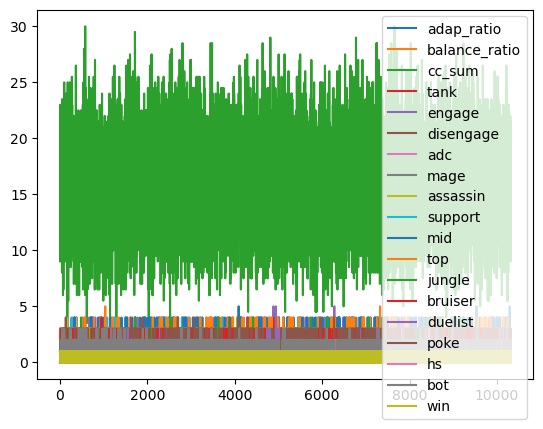

In [81]:
df.plot()

In [82]:
df.describe()

,adap_ratio,balance_ratio,cc_sum,tank,engage,disengage,adc,mage,assassin,support,mid,top,jungle,bruiser,duelist,poke,hs,bot,win
count,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000
mean,0.809727,0.891300,15.711732,1.124782,1.182717,0.555319,1.114900,1.313990,0.973455,1.370665,1.693567,1.614319,1.360298,1.101240,0.551153,0.786088,0.422689,1.074501,0.500000
std,0.132269,0.144088,4.019928,0.843613,0.907365,0.616986,0.483597,0.807829,0.797045,0.680100,0.793452,0.742994,0.647194,0.772505,0.632079,0.784853,0.529235,0.432847,0.500024
min,0.160000,0.200000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.760000,0.800000,13.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.840000,1.000000,15.500000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000
75%,0.900000,1.000000,18.500000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,30.000000,4.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,3.000000,3.000000,1.000000


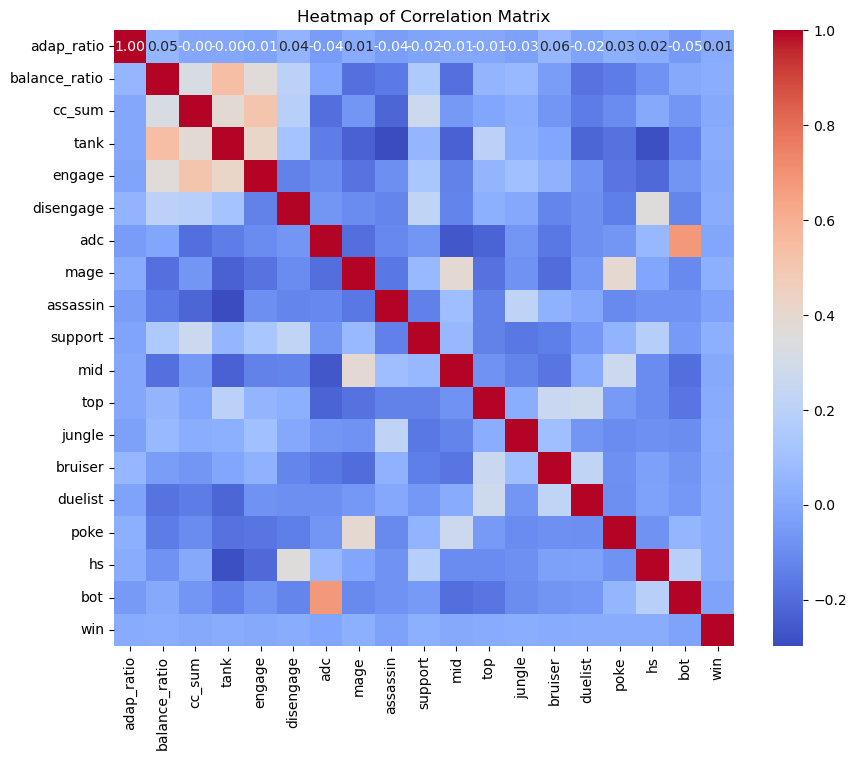

In [86]:
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")  # Adjust parameters as needed
plt.title("Heatmap of Correlation Matrix")  # Optional: Add a title
plt.show()

# Training The Model

# Sequential

In [19]:
# X = features
X = df.drop('win', axis=1)
# y = label
y = df['win']

# Standardize data
scaler = MinMaxScaler()
scaler.fit(df)
t_df = scaler.transform(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(t_df, y, test_size=0.25, random_state=97)
num_features = X_train.shape[1]

# Define model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(units=64, input_shape=(num_features,), activation='relu', kernel_initializer='he_normal'))

# Add second hidden layer
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))  # Regularization to prevent overfitting

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Optimizer
adam = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=adam, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Training time
model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test)) #, batch_size=14, verbose=1, validation_data=(X_test, y_test)

# Decision Tree

Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1236
           1       0.53      0.51      0.52      1345

    accuracy                           0.51      2581
   macro avg       0.51      0.51      0.51      2581
weighted avg       0.51      0.51      0.51      2581



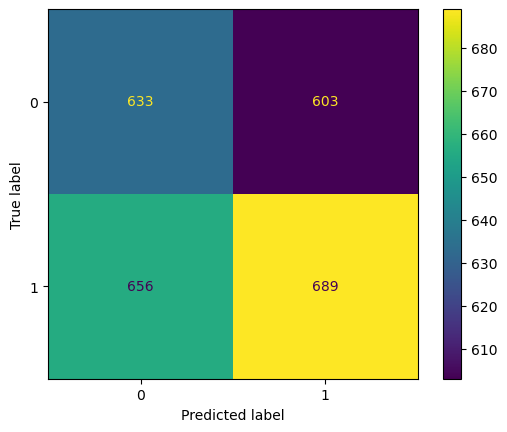

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# X = features
X = df.drop('win', axis=1)
# y = label
y = df['win']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=97)

# Define the Decision Tree model
model = DecisionTreeClassifier(
    criterion='gini',        # or 'entropy'
    max_depth=None,          # Limit the depth of the tree, e.g., max_depth=10
    min_samples_split=2,     # Minimum samples required to split a node
    min_samples_leaf=1,      # Minimum samples required in a leaf node
    random_state=97          # Ensure reproducibility
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

# Using Deployment (AWS)

In [86]:
# Ensure Rate limiter for limiting API requests is running

In [3]:
# PLACE SUMMONER_ID HERE
gameName = "Purham"
tagLine = "33333"
summoner_id = utils.get_puuid(gameName, tagLine, RATE_LIMITER)
# Gets the live data
print(utils.get_live_data(summoner_id, RATE_LIMITER))

Error: Data not found
Inserting default champ_mastery, stats: None
{'summoner_id': 'oPVyM8Y6JMx0Ic6NGIiv8HHmvWU3YFYlf6Ie5gNC97P9DJRBWfVdMargcBS43IHeomB3-ildz8RBGQ', 'time': datetime.datetime(2025, 1, 8, 19, 45, 49, 667198), 'avg_summoner_lvl_ally': 445.4, 'avg_match_history_length_ally': 20.0, 'avg_win_rate_ally': 0.49, 'sum_champ_mastery_ally': 178782, 'avg_summoner_lvl_enemy': 309.2, 'avg_match_history_length_enemy': 20.0, 'avg_win_rate_enemy': 0.46, 'sum_champ_mastery_enemy': 1814650, 'win': -1}


In [1]:
"""
import io
#AWS
import io

# Create a DataFrame with your data
df = pd.DataFrame({
    'win':[0],
    '1': [392],
    '2': [20],
    '4': [0.47],
    '5': [2333535],
    '6': [280],
    '7': [20],
    '8': [0.45],
    '9': [554507]
})

# Convert DataFrame to CSV string without header
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False, header=False)  # Exclude header
csv_data = csv_buffer.getvalue()

import boto3

# Initialize a Boto3 client for SageMaker Runtime
client = boto3.client('sagemaker-runtime')

# Define your endpoint name
endpoint_name = 'game-outcomes'

# Make a prediction request
response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=csv_data,  # CSV data without headers
    ContentType='text/csv'  # Set content type to CSV
)

# Print the result
print(response['Body'].read().decode())
"""

"\nimport io\n#AWS\nimport io\n\n# Create a DataFrame with your data\ndf = pd.DataFrame({\n    'win':[0],\n    '1': [392],\n    '2': [20],\n    '4': [0.47],\n    '5': [2333535],\n    '6': [280],\n    '7': [20],\n    '8': [0.45],\n    '9': [554507]\n})\n\n# Convert DataFrame to CSV string without header\ncsv_buffer = io.StringIO()\ndf.to_csv(csv_buffer, index=False, header=False)  # Exclude header\ncsv_data = csv_buffer.getvalue()\n\nimport boto3\n\n# Initialize a Boto3 client for SageMaker Runtime\nclient = boto3.client('sagemaker-runtime')\n\n# Define your endpoint name\nendpoint_name = 'game-outcomes'\n\n# Make a prediction request\nresponse = client.invoke_endpoint(\n    EndpointName=endpoint_name,\n    Body=csv_data,  # CSV data without headers\n    ContentType='text/csv'  # Set content type to CSV\n)\n\n# Print the result\nprint(response['Body'].read().decode())\n"